<a href="https://colab.research.google.com/github/yaaili/test/blob/master/pytorch/03%E5%9F%BA%E4%BA%8EFashionMNIST%E7%9A%84%E6%A8%A1%E5%9E%8B%E5%89%AA%E6%9E%9D(%E8%87%AA%E5%AE%9A%E4%B9%89).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 导入相关包

In [6]:
# 导入相关包
from google.colab import drive

drive.mount('/content/gdrive')
import os

os.chdir("/content/gdrive/My Drive/Colab Notebooks/pytorch深度学习")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
import torch
from torch import nn
import torch.nn.functional as F
print(torch.__version__)

1.5.0+cu101


# 2 构建网络

In [0]:
import torch
import numpy as np
from matplotlib import pyplot as plt


def to_var(x, requires_grad=False):
    """
    Automatically choose cpu or cuda
    """
    if torch.cuda.is_available():
        x = x.cuda()
    return x.clone().detach().requires_grad_(requires_grad)


def weight_prune(model, pruning_perc):
    '''
    Prune pruning_perc % weights layer-wise
    '''
    threshold_list = []
    line = np.array([],dtype=np.float32)
    for p in model.parameters():
        if len(p.data.size()) != 1:  # bias
            if len(p.data.size()) != 4:
                weight = p.cpu().data.abs().numpy().flatten()
                line = np.hstack((line,weight))
    threshold = np.percentile(line, pruning_perc)

    # generate mask
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            if len(p.data.size()) != 4:
                pruned_inds = p.data.abs() > threshold
                masks.append(pruned_inds.float())
    return masks


"""Reference https://github.com/zepx/pytorch-weight-prune/"""


def prune_rate(model, verbose=False):
    """
    Print out prune rate for each layer and the whole network
    """
    total_nb_param = 0
    nb_zero_param = 0

    layer_id = 0

    for parameter in model.parameters():

        param_this_layer = 1
        for dim in parameter.data.size():
            param_this_layer *= dim
        total_nb_param += param_this_layer

        # only pruning linear and conv layers
        if len(parameter.data.size()) != 1:
            layer_id += 1
            zero_param_this_layer = np.count_nonzero(parameter.cpu().data.numpy() == 0)
            nb_zero_param += zero_param_this_layer

            if verbose:
                print("Layer {} | {} layer | {:.2f}% parameters pruned".format(
                    layer_id,
                    'Conv' if len(parameter.data.size()) == 4 \
                        else 'Linear',
                    100. * zero_param_this_layer / param_this_layer,
                ))
    pruning_perc = 100. * nb_zero_param / total_nb_param
    if verbose:
        print("Final pruning rate: {:.2f}%".format(pruning_perc))
    return pruning_perc


def arg_nonzero_min(a):
    """
    nonzero argmin of a non-negative array
    """

    if not a:
      return

    min_ix, min_v = None, None
    # find the starting value (should be nonzero)
    for i, e in enumerate(a):
        if e != 0:
            min_ix = i
            min_v = e
    if not min_ix:
        print('Warning: all zero')
        return np.inf, np.inf

    # search for the smallest nonzero
    for i, e in enumerate(a):
        if e < min_v and e != 0:
            min_v = e
            min_ix = i

    return min_v, min_ix


def prune_one_filter(model, masks):
    '''
    Pruning one least ``important'' feature map by the scaled l2norm of
    kernel weights
    arXiv:1611.06440
    '''
    NO_MASKS = False
    # construct masks if there is not yet
    if not masks:
        masks = []
        NO_MASKS = True

    values = []
    for p in model.parameters():

        if len(p.data.size()) == 4:  # nasty way of selecting conv layer
            p_np = p.data.cpu().numpy()
           

            # construct masks if there is not
            if NO_MASKS:
                masks.append(np.ones(p_np.shape).astype('float32'))

#            # find the scaled l2 norm for each filter this layer
#            value_this_layer = np.square(p_np).sum(axis=1).sum(axis=1).sum(axis=1) / (
#                    p_np.shape[1] * p_np.shape[2] * p_np.shape[3])
#            # normalization (important)
#           value_this_layer = value_this_layer / np.sqrt(np.square(value_this_layer).sum())
            # 找到通道值的最小值以及索引
            p_np = torch.from_numpy(p_np)
            dims = list(range(1,p_np.dim()))
            value_this_layer = torch.norm(p_np, p=1, dim=dims)/(p_np.shape[1] * p_np.shape[2] * p_np.shape[3])
            value_this_layer = value_this_layer/ np.sqrt(np.square(value_this_layer).sum())
            min_value, min_ind = arg_nonzero_min(list(value_this_layer.numpy()))
            values.append([min_value, min_ind])
            #print(value_this_layer)

    assert len(masks) == len(values), "something wrong here"

    values = np.array(values)

    # set mask corresponding to the filter to prune
    to_prune_layer_ind = np.argmin(values[:, 0])
    to_prune_filter_ind = int(values[to_prune_layer_ind, 1])
    masks[to_prune_layer_ind][to_prune_filter_ind] = 0.

    #     print('Prune filter #{} in layer #{}'.format(
    #         to_prune_filter_ind,
    #         to_prune_layer_ind))

    return masks


def filter_prune(model, pruning_perc):
    '''
    Prune filters one by one until reach pruning_perc
    (not iterative pruning)
    '''
    masks = []
    current_pruning_perc = 0.

    while current_pruning_perc < pruning_perc:
        masks = prune_one_filter(model, masks)
        model.set_masks(masks)
        current_pruning_perc = prune_rate(model, verbose=False)
    #         print('{:.2f} pruned'.format(current_pruning_perc))
    return masks


def plot_weights(model):
    modules = [module for module in model.modules()]
    num_sub_plot = 0
    for i, layer in enumerate(modules):
        print(i)
        if hasattr(layer, 'weight'):
            plt.subplot(131 + num_sub_plot)
            w = layer.weight.data
            w_one_dim = w.cpu().numpy().flatten()
            plt.hist(w_one_dim[w_one_dim != 0], bins=50)
            num_sub_plot += 1
    plt.show()


In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False

    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, data):
        if self.mask_flag:
            weight = self.weight * self.mask
            return F.conv2d(data, weight, self.bias, self.stride,
                            self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(data, self.weight, self.bias, self.stride,
                            self.padding, self.dilation, self.groups)


class MaskedLinear(nn.Linear):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__(in_channels, out_channels, bias)
        self.mask_flag = False

    def set_mask(self, mask):
        self.mask = to_var(mask, requires_grad=False)
        self.weight.data = self.weight.data * self.mask.data
        self.mask_flag = True

    def get_mask(self):
        print(self.mask_flag)
        return self.mask

    def forward(self, data):
        if self.mask_flag:
            weight = self.weight * self.mask
            return F.linear(data, weight, self.bias)
        else:
            return F.linear(data, self.weight, self.bias)


class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = MaskedConv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = MaskedConv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = MaskedConv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.linear1 = MaskedLinear(7 * 7 * 64, 128)
        self.linear2 = MaskedLinear(128, 10)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, data):
        out = self.maxpool1(self.relu1(self.conv1(data)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = self.relu3(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

    def get_loss(self, output, label):
        return self.loss(output, label)

    def set_masks(self, masks, isLinear=False):
        # Should be a less manual way to set masks
        # Leave it for the future
        if isLinear:
            self.linear1.set_mask(masks[0])
            self.linear2.set_mask(masks[1])
        else:
            self.conv1.set_mask(torch.from_numpy(masks[0]))
            self.conv2.set_mask(torch.from_numpy(masks[1]))
            self.conv3.set_mask(torch.from_numpy(masks[2]))



# 3 训练

In [0]:
import torch
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
import math
import time

## 3.1 数据准备

In [0]:
#图像的预处理归一化[0,1],transforms.Normalize即image=(image-mean)/std到[-1,1]
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
#加载训练集,不是独热编码
train_data = DataLoader(datasets.FashionMNIST("./datasets/", train=True, transform=trans, download=True),
                              batch_size=100, shuffle=True, drop_last=True)
#加载测试集
test_data = DataLoader(datasets.FashionMNIST("./datasets/", train=False, transform=trans, download=True),
                               batch_size=100, shuffle=True, drop_last=True)

In [12]:
for X,y in train_data:
    print(X.shape,y.shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [0]:
class Trainer:
    def __init__(self, save_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.save_path = save_path
        self.net = MyNet().to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters())
        self.net.train()
        
    def evaluate_accuracy(self,test_data):
        acc_sum, n = 0.0, 0
        for X, y in test_data:
            X, y = X.to(self.device), y.to(self.device)
            if isinstance(self.net, torch.nn.Module):
                self.net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (self.net(X).argmax(dim=1) == y).float().sum().item()
                self.net.train() # 改回训练模式
            else: # 自定义的模型
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (self.net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (self.net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
        return acc_sum / n

    def train(self,train_data,test_data,epochs):
        for epoch in range(1, epochs):
            total = 0
            train_acc_sum,train_l_sum,n,start = 0.0,0.0,0,time.time()
            for i, (data, label) in enumerate(train_data):
                data, label = data.to(self.device), label.to(self.device)
                output = self.net(data)
                loss = self.net.get_loss(output, label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total += len(data)
                #训练损失
                train_l_sum += loss.item()
                train_acc_sum += ((output.argmax(dim=1)) == label).sum().item()
                n += 100  
                progress = math.ceil(i / len(train_data) * 50)
                print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
                      (epoch, total, len(train_data.dataset),
                       '-' * progress + '>', progress * 2), end='')
            test_acc = self.evaluate_accuracy(test_data)
            print("\nepoch %d,loss %.4f, train_acc %.3f, test_acc %.3f,time %.1f sec"
              %(epoch,train_l_sum/n,train_acc_sum/n,test_acc,time.time()-start))
              
            torch.save(self.net.state_dict(), self.save_path)





In [17]:
if __name__ == '__main__':
    trainer = Trainer("./model/finsh_minst_net.pth")
    trainer.train(train_data,test_data,epochs=10)

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
epoch 1,loss 0.0045, train_acc 0.839, test_acc 0.885,time 22.9 sec
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
epoch 2,loss 0.0028, train_acc 0.898, test_acc 0.900,time 22.9 sec
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
epoch 3,loss 0.0024, train_acc 0.912, test_acc 0.902,time 22.9 sec
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
epoch 4,loss 0.0021, train_acc 0.923, test_acc 0.905,time 23.1 sec
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
epoch 5,loss 0.0019, train_acc 0.932, test_acc 0.909,time 23.0 sec
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
epoch 6,loss 0.0017, train_acc 0.938, test_acc 0.920,time 23.0 sec
Train epoch 7: 60000/60000, [-----------------------------------------------

# 4 对模型进行剪枝
## 4.1 构建剪枝网络

In [51]:
net = MyNet().to("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("./model/finsh_minst_net.pth"))
#剪枝
prune_rate(net,verbose=True)
for i in range(1,10):
  mask = weight_prune(net,i*10)
  net.set_masks(mask, isLinear=True)
  _=filter_prune(net,i*10)
  prune_rate(net,verbose=True)
  amount = 0.1*i
  torch.save(net.state_dict(), f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Linear layer | 0.00% parameters pruned
Layer 5 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%
Layer 1 | Conv layer | 9.38% parameters pruned
Layer 2 | Conv layer | 9.38% parameters pruned
Layer 3 | Conv layer | 10.94% parameters pruned
Layer 4 | Linear layer | 10.02% parameters pruned
Layer 5 | Linear layer | 3.59% parameters pruned
Final pruning rate: 10.04%
Layer 1 | Conv layer | 12.50% parameters pruned
Layer 2 | Conv layer | 25.00% parameters pruned
Layer 3 | Conv layer | 18.75% parameters pruned
Layer 4 | Linear layer | 20.04% parameters pruned
Layer 5 | Linear layer | 7.89% parameters pruned
Final pruning rate: 20.08%
Layer 1 | Conv layer | 18.75% parameters pruned
Layer 2 | Conv layer | 37.50% parameters pruned
Layer 3 | Conv layer | 28.12% parameters pruned
Layer 4 | Linear layer | 30.06% parameters pruned
Lay

In [52]:
net = MyNet().to("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("./model/finsh_minst_net.pth"))
#剪枝
prune_rate(net,verbose=True)
for i in range(1,10):
  mask = weight_prune(net,i*10)
  net.set_masks(mask, isLinear=True)
  _=filter_prune(net,i*0)
  prune_rate(net,verbose=True)
  amount = 0.1*i
  torch.save(net.state_dict(), f"./model/pruned_net_with_torch_{amount:.1f}_weight_l1.pth")

Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Linear layer | 0.00% parameters pruned
Layer 5 | Linear layer | 0.00% parameters pruned
Final pruning rate: 0.00%
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Linear layer | 10.02% parameters pruned
Layer 5 | Linear layer | 3.59% parameters pruned
Final pruning rate: 8.78%
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Linear layer | 20.04% parameters pruned
Layer 5 | Linear layer | 7.89% parameters pruned
Final pruning rate: 17.56%
Layer 1 | Conv layer | 0.00% parameters pruned
Layer 2 | Conv layer | 0.00% parameters pruned
Layer 3 | Conv layer | 0.00% parameters pruned
Layer 4 | Linear layer | 30.06% parameters pruned
Layer 5 | L

# 5 检测

In [57]:
class Detector:
    def __init__(self, net_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = MyNet().to(self.device)
        self.map_location = None if torch.cuda.is_available() else lambda storage, loc: storage
        self.net.load_state_dict(torch.load(net_path, map_location=self.map_location))
        self.net.eval()

    def detect(self,test_data):
        test_loss = 0
        correct = 0
        start = time.time()
        with torch.no_grad():
            for data, label in test_data:
                data, label = data.to(self.device), label.to(self.device)
                output = self.net(data)
                test_loss += self.net.get_loss(output, label)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(label.view_as(pred)).sum().item()

        end = time.time()
        print(f"total time:{end - start}")
        test_loss /= len(test_data.dataset)

        print('Test: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_data.dataset),
            100. * correct / len(test_data.dataset)))
        #返回的损失和正确率
        return [test_loss,correct/len(test_data.dataset)]


if __name__ == '__main__':
    print("./model/finsh_minst_net.pth")
    test_loss,accuracy,Parameter_compression_ratio = [],[],[]
    detector1 = Detector("./model/finsh_minst_net.pth")
    loss,acc = detector1.detect(test_data)

    test_loss.append(loss)
    accuracy.append(acc)   
    Parameter_compression_ratio.append(0)
     
    for i in range(1, 10):
        amount = 0.1 * i
        print(f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")
        detector1 = Detector(f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")
        loss,acc = detector1.detect(test_data)

        test_loss.append(loss)
        accuracy.append(acc)   
        Parameter_compression_ratio.append(amount)


./model/finsh_minst_net.pth
total time:2.36423397064209
Test: average loss: 0.0025, accuracy: 9155/10000 (92%)

./model/pruned_net_with_torch_0.1_l1.pth
total time:2.34464693069458
Test: average loss: 0.0027, accuracy: 9067/10000 (91%)

./model/pruned_net_with_torch_0.2_l1.pth
total time:2.3698177337646484
Test: average loss: 0.0029, accuracy: 8995/10000 (90%)

./model/pruned_net_with_torch_0.3_l1.pth
total time:2.369694471359253
Test: average loss: 0.0034, accuracy: 8834/10000 (88%)

./model/pruned_net_with_torch_0.4_l1.pth
total time:2.4069736003875732
Test: average loss: 0.0043, accuracy: 8621/10000 (86%)

./model/pruned_net_with_torch_0.5_l1.pth
total time:2.3909096717834473
Test: average loss: 0.0089, accuracy: 6789/10000 (68%)

./model/pruned_net_with_torch_0.6_l1.pth
total time:2.366197109222412
Test: average loss: 0.0138, accuracy: 4626/10000 (46%)

./model/pruned_net_with_torch_0.7_l1.pth
total time:2.374626874923706
Test: average loss: 0.0211, accuracy: 2676/10000 (27%)

./mo

In [58]:
class Detector:
    def __init__(self, net_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = MyNet().to(self.device)
        self.map_location = None if torch.cuda.is_available() else lambda storage, loc: storage
        self.net.load_state_dict(torch.load(net_path, map_location=self.map_location))
        self.net.eval()

    def detect(self,test_data):
        test_loss = 0
        correct = 0
        start = time.time()
        with torch.no_grad():
            for data, label in test_data:
                data, label = data.to(self.device), label.to(self.device)
                output = self.net(data)
                test_loss += self.net.get_loss(output, label)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(label.view_as(pred)).sum().item()

        end = time.time()
        print(f"total time:{end - start}")
        test_loss /= len(test_data.dataset)

        print('Test: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_data.dataset),
            100. * correct / len(test_data.dataset)))
        #返回的损失和正确率
        return [test_loss,correct/len(test_data.dataset)]


if __name__ == '__main__':
    print("./model/finsh_minst_net.pth")
    test_loss_w,accuracy_w,Parameter_compression_ratio_w = [],[],[]
    detector1 = Detector("./model/finsh_minst_net.pth")
    loss,acc = detector1.detect(test_data)

    test_loss_w.append(loss)
    accuracy_w.append(acc)   
    Parameter_compression_ratio_w.append(0)
     
    for i in range(1, 10):
        amount = 0.1 * i
        print(f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")
        detector1 = Detector(f"./model/pruned_net_with_torch_{amount:.1f}_weight_l1.pth")
        loss,acc = detector1.detect(test_data)

        test_loss_w.append(loss)
        accuracy_w.append(acc)   
        Parameter_compression_ratio_w.append(amount)


./model/finsh_minst_net.pth
total time:2.416531801223755
Test: average loss: 0.0025, accuracy: 9155/10000 (92%)

./model/pruned_net_with_torch_0.1_l1.pth
total time:2.4031946659088135
Test: average loss: 0.0025, accuracy: 9155/10000 (92%)

./model/pruned_net_with_torch_0.2_l1.pth
total time:2.3649911880493164
Test: average loss: 0.0025, accuracy: 9149/10000 (91%)

./model/pruned_net_with_torch_0.3_l1.pth
total time:2.409180164337158
Test: average loss: 0.0025, accuracy: 9150/10000 (92%)

./model/pruned_net_with_torch_0.4_l1.pth
total time:2.3315677642822266
Test: average loss: 0.0025, accuracy: 9155/10000 (92%)

./model/pruned_net_with_torch_0.5_l1.pth
total time:2.380612373352051
Test: average loss: 0.0025, accuracy: 9152/10000 (92%)

./model/pruned_net_with_torch_0.6_l1.pth
total time:2.3330729007720947
Test: average loss: 0.0024, accuracy: 9163/10000 (92%)

./model/pruned_net_with_torch_0.7_l1.pth
total time:2.2958364486694336
Test: average loss: 0.0024, accuracy: 9154/10000 (92%)



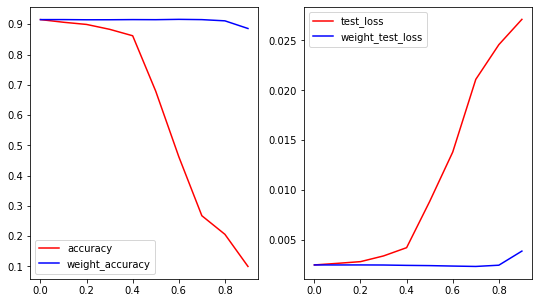

In [60]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(9,5))
ax1 = plt.subplot(121)  #绘制子图1对象
ax2 = plt.subplot(122)  #绘制子图2对象



x = Parameter_compression_ratio
y = accuracy
y_w = accuracy_w
y2 = test_loss
y2_w = test_loss_w

ax1.plot(x,y,color='red',label='accuracy')
ax1.plot(x,y_w,color='blue',label='weight_accuracy')
ax2.plot(x,y2,color='red',label='test_loss')
ax2.plot(x,y2_w,color='blue',label='weight_test_loss')
ax1.legend()
ax2.legend()

plt.show()